In [1]:
import time
import re
import datetime as pydt
import pandas as pd
%matplotlib inline

In [2]:
def parse_reset_time(line):
    line = line.strip()
    line = line.split("RESET:TIME: ", 1)[1]
    #The method split() returns a list of all the words in the string"line" 
    # -using 1st arg as the separator, and 2nd arg to limit the number of splits
    
    st = time.strptime(line, "%Y-%m-%d-%H-%M-%S") #returns <type 'time.struct_time'>
    #The method strptime() parses a string representing a time according to a format.
    
    return time.mktime(st) #returns <type 'float'> (unix time)
    #The method mktime() is the inverse function of localtime(). 
    # -Its argument is the struct_time or full 9-tuple and it returns a floating point number, for compatibility with time().

In [15]:
def parse_time(s, fmt):
    """Parses a human readable duration string into milliseconds.
    Takes a human readable duration string like '1d2h3m4s5ms' and returns
    the equivalent in milliseconds.
    Args:
    -s: Duration string
    -fmt: A re object to parse the string
    Returns:
    -A number indicating the duration in milliseconds.
    """
    if s == "0": return 0.0

    p = re.compile(fmt)
    match = p.search(s)
    try:
        d = match.groupdict()
    except IndexError:
        return -1.0

    ret = 0.0
    if d["day"]: ret += float(d["day"])*60*60*24
    if d["hrs"]: ret += float(d["hrs"])*60*60
    if d["min"]: ret += float(d["min"])*60
    if d["sec"]: ret += float(d["sec"])
    if d["ms"]: ret += float(d["ms"])/1000
    return ret

In [37]:
filename = 'batterystats.txt'

with open(filename) as file_object: 
    lines = file_object.readlines() #returns list of strings 
    
battery_list = [] 
ts_list = []
dt_list = []
prev_battery_level = -1

last_line = lines[-1]
last_time = last_line.split()[0]
print last_time
fmt = (r"\-((?P<day>\d+)d)?((?P<hrs>\d+)h)?((?P<min>\d+)m)?"
           r"((?P<sec>\d+)s)?((?P<ms>\d+)ms)?$")
last_ts = parse_time(last_time, fmt)
st = time.strptime('2016-08-01-20-38-00', "%Y-%m-%d-%H-%M-%S")
data_start_time = time.mktime(st) + last_ts 

for i, line in enumerate(lines): 
    line.rstrip()
    if len(line.strip()) == 0: #empty line b/t battery data and "Per-PID Stats:"
        break
    
    if i!=0: 
        data = line.split()
        line_time = data[0] #duration like '1d2h3m4s5ms' (string)
        line_battery_level = int(data[1]) #battery percentage (int)

        fmt = (r"\-((?P<day>\d+)d)?((?P<hrs>\d+)h)?((?P<min>\d+)m)?"
           r"((?P<sec>\d+)s)?((?P<ms>\d+)ms)?$")
        time_delta_s = parse_time(line_time, fmt) #duration in seconds (float)
        ts = data_start_time - time_delta_s #unix time (float)       
        local_time = pydt.datetime.fromtimestamp(ts) #local time (datetime)

        battery_list.append(line_battery_level)
        ts_list.append(ts)
        dt_list.append(local_time)

        if line_battery_level != prev_battery_level:
            print str(local_time) + " " + str(line_battery_level) + " "+ str(type(line_battery_level))

        prev_battery_level = line_battery_level
    
    #if line_battery_level == 0: #battery drained completely
     #   break

-11m50s325ms
2016-08-01 19:18:07.203000 99 <type 'int'>
2016-08-01 19:19:00.490000 97 <type 'int'>
2016-08-01 19:20:07.170000 95 <type 'int'>
2016-08-01 19:21:07.261000 93 <type 'int'>
2016-08-01 19:22:10.897000 91 <type 'int'>
2016-08-01 19:23:00.927000 90 <type 'int'>
2016-08-01 19:23:50.966000 89 <type 'int'>
2016-08-01 19:24:40.986000 87 <type 'int'>
2016-08-01 19:25:31.009000 86 <type 'int'>
2016-08-01 19:26:21.034000 85 <type 'int'>
2016-08-01 19:27:11.058000 83 <type 'int'>
2016-08-01 19:28:01.749000 82 <type 'int'>
2016-08-01 19:28:51.779000 81 <type 'int'>
2016-08-01 19:29:41.811000 80 <type 'int'>
2016-08-01 19:30:35.207000 78 <type 'int'>
2016-08-01 19:31:25.231000 77 <type 'int'>
2016-08-01 19:32:15.253000 76 <type 'int'>
2016-08-01 19:33:05.275000 75 <type 'int'>
2016-08-01 19:33:55.300000 74 <type 'int'>
2016-08-01 19:34:45.323000 72 <type 'int'>
2016-08-01 19:35:35.356000 71 <type 'int'>
2016-08-01 19:36:29.288000 70 <type 'int'>
2016-08-01 19:37:19.310000 69 <type 'int'

In [38]:
df = pd.DataFrame(data={'metadata_write_ts': ts_list, 'ts': ts_list, 'local_dt': dt_list, 'battery_level_pct': battery_list})
df.to_csv('batterystats.csv')
df[:3]

,battery_level_pct,local_dt,metadata_write_ts,ts
0,99,2016-08-01 19:18:07.203,1.470104e+09,1.470104e+09
1,99,2016-08-01 19:18:08.728,1.470104e+09,1.470104e+09
2,99,2016-08-01 19:18:09.656,1.470104e+09,1.470104e+09


In [39]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 4 columns):
battery_level_pct    110 non-null int64
local_dt             110 non-null datetime64[ns]
metadata_write_ts    110 non-null float64
ts                   110 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 3.5 KB


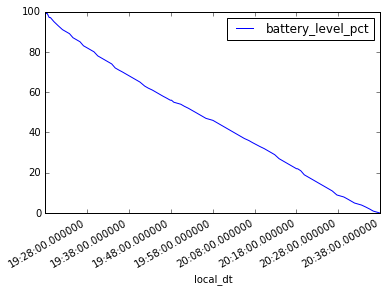

In [47]:
df.plot(x='local_dt', y='battery_level_pct')

In [48]:
df1 = pd.read_csv('batterystats.csv')
df2 = pd.read_csv('batterystats1.5.csv')

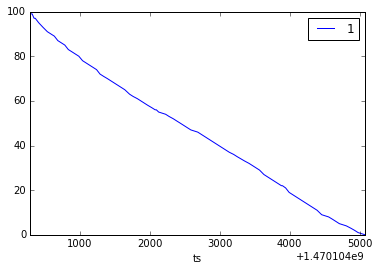

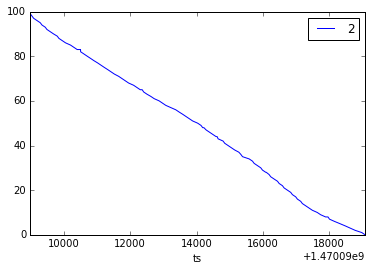

In [49]:
df1.plot(x='ts', y='battery_level_pct', label='1')
df2.plot(x='ts', y='battery_level_pct', label='2')